# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [0]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

CAT = ['department'
,'region'
,'education'
,'gender'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [0]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [0]:
dataprep_df_full = pd.read_csv('https://raw.githubusercontent.com/maxreis86/FIEP-Machine-Learning-e-Computacao-em-Nuvem/main/aula_03_hr_analytics_keras/HR_Analytics/dataprep_df.csv')

In [0]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [0]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

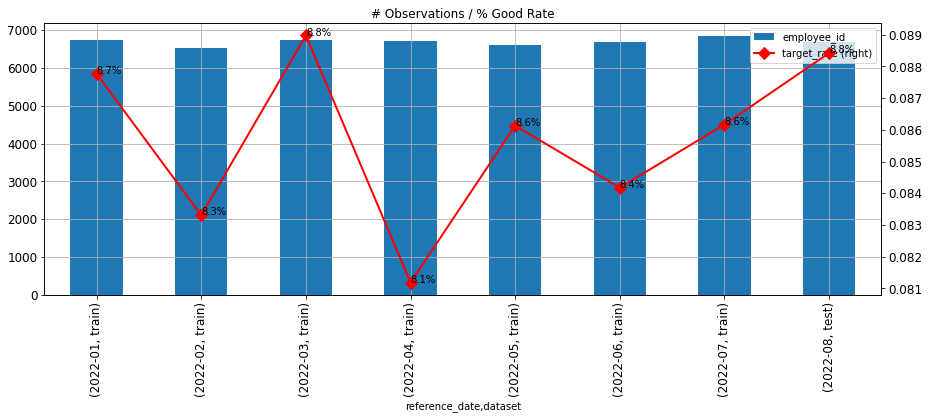

In [0]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [0]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [0]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [0]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: '
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1)
#       + " | "
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Spark ML

In [0]:
trainDF  = spark.createDataFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])
testDF  = spark.createDataFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
 
categoricalCols = CAT
 
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]) 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 
 
# The label column ("income") is also a string value - it has two possible values, "<=50K" and ">50K". 
# Convert it to a numeric value using StringIndexer.
labelToIndex = StringIndexer(inputCol=VarTarget, outputCol="label")

In [0]:
stringIndexerModel = stringIndexer.fit(trainDF)
display(stringIndexerModel.transform(trainDF))

department,region,education,gender,recruitment_channel,kpis_met_80,no_of_trainings,previous_year_rating,age,length_of_service,avg_training_score,is_promoted,departmentIndex,regionIndex,educationIndex,genderIndex,recruitment_channelIndex,kpis_met_80Index
Sales & Marketing,region_7,Master's & above,f,sourcing,1,1.0,5.0,35.0,8.0,49.0,0,0.0,2.0,1.0,1.0,1.0,1.0
Operations,region_22,Bachelor's,m,other,0,1.0,5.0,30.0,4.0,60.0,0,1.0,1.0,0.0,0.0,0.0,0.0
Sales & Marketing,region_19,Bachelor's,m,sourcing,0,1.0,3.0,34.0,7.0,50.0,0,0.0,15.0,0.0,0.0,1.0,0.0
Sales & Marketing,region_23,Bachelor's,m,other,0,2.0,1.0,39.0,10.0,50.0,0,0.0,12.0,0.0,0.0,0.0,0.0
Operations,region_34,Master's & above,m,sourcing,0,1.0,3.0,33.0,6.0,63.0,0,1.0,31.0,1.0,0.0,1.0,0.0
Analytics,region_20,Bachelor's,m,other,0,1.0,4.0,28.0,5.0,83.0,0,4.0,16.0,0.0,0.0,0.0,0.0
Sales & Marketing,region_1,Master's & above,m,sourcing,1,1.0,5.0,32.0,5.0,54.0,0,0.0,25.0,1.0,0.0,1.0,1.0
Sales & Marketing,region_7,Bachelor's,f,sourcing,1,1.0,5.0,35.0,3.0,50.0,1,0.0,2.0,0.0,1.0,1.0,1.0
Sales & Marketing,region_4,Bachelor's,m,sourcing,1,1.0,5.0,49.0,5.0,49.0,0,0.0,7.0,0.0,0.0,1.0,1.0
Technology,region_29,Master's & above,m,other,0,2.0,3.0,39.0,16.0,80.0,0,2.0,13.0,1.0,0.0,0.0,0.0


In [0]:
from pyspark.ml.feature import VectorAssembler
 
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
numericCols = NUM
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [0]:
from pyspark.ml.classification import LogisticRegression
 
lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)

from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [0]:
from pyspark.ml import Pipeline
 
# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, gbt])
 
# Define the pipeline model.
pipelineModel = pipeline.fit(trainDF)
 
# Apply the pipeline model to the test dataset.
predDF = pipelineModel.transform(testDF)

In [0]:
# Select example rows to display.
predDF.select("prediction", "label", "features").show(5, truncate=False)

# Select (prediction, true label) and compute test error
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predDF)
print("Test Accuracy = %g" % (accuracy))

+----------+-----+----------------------------------------------------------------------------------------------------+
|prediction|label|features                                                                                            |
+----------+-----+----------------------------------------------------------------------------------------------------+
|0.0       |0.0  |(53,[2,13,41,44,45,47,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,45.0,2.0,73.0])              |
|0.0       |0.0  |(53,[4,8,41,44,46,47,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,31.0,7.0,85.0])               |
|0.0       |0.0  |(53,[1,24,41,45,47,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,3.0,31.0,5.0,59.0])                     |
|0.0       |0.0  |(53,[2,20,43,44,46,47,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.329255780917055,30.0,1.0,77.0])|
|0.0       |0.0  |(53,[1,10,41,44,45,47,48,49,50,51,52],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,37.0,10.0,60.0])             |
+----------+-----+----------------------

In [0]:
predDF.select("label", "prediction").toPandas()

,label,prediction
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
6679,0.0,0.0
6680,0.0,0.0
6681,0.0,0.0
6682,0.0,0.0


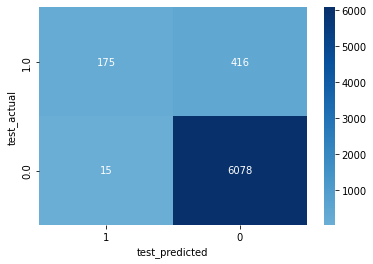

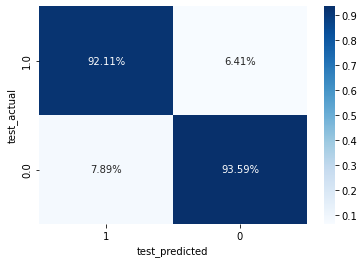

In [0]:
spark_predict_df = predDF.select("label", "prediction").toPandas().rename(columns={'label':'test_actual', 'prediction':'test_predicted'})

spark_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False)
df_matrix = spark_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False).loc[:,(1,0)]
sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 4.1.2 Spark ML Submision dataset

In [0]:
submission_df = pd.read_csv('https://raw.githubusercontent.com/maxreis86/FIEP-Machine-Learning-e-Computacao-em-Nuvem/main/aula_03_hr_analytics_keras/HR_Analytics/submission_df.csv')

In [0]:
submissionDF  = spark.createDataFrame(submission_df)

In [0]:
# Apply the pipeline model to the test dataset.
submission_predDF = pipelineModel.transform(submissionDF)
submission_predDF.printSchema()

root
 |-- employee_id: long (nullable = true)
 |-- department: string (nullable = true)
 |-- region: string (nullable = true)
 |-- education: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- recruitment_channel: string (nullable = true)
 |-- kpis_met_80: long (nullable = true)
 |-- no_of_trainings: long (nullable = true)
 |-- previous_year_rating: double (nullable = true)
 |-- age: long (nullable = true)
 |-- length_of_service: long (nullable = true)
 |-- avg_training_score: long (nullable = true)
 |-- departmentIndex: double (nullable = false)
 |-- regionIndex: double (nullable = false)
 |-- educationIndex: double (nullable = false)
 |-- genderIndex: double (nullable = false)
 |-- recruitment_channelIndex: double (nullable = false)
 |-- kpis_met_80Index: double (nullable = false)
 |-- departmentOHE: vector (nullable = true)
 |-- regionOHE: vector (nullable = true)
 |-- educationOHE: vector (nullable = true)
 |-- genderOHE: vector (nullable = true)
 |-- recruitment_c

In [0]:
#Importar MOJO
predict_df = submission_predDF.select('employee_id', 'prediction')\
.withColumnRenamed('prediction', 'is_promoted')\
.repartition(1).write.mode("overwrite").format("csv").save('dbfs:/FileStore/Spark_ML_submission', index=False)

In [0]:
%fs
ls dbfs:/FileStore/Spark_ML_submission

path,name,size,modificationTime
dbfs:/FileStore/Spark_ML_submission/_SUCCESS,_SUCCESS,0,1671291557000
dbfs:/FileStore/Spark_ML_submission/_committed_1725127993048767971,_committed_1725127993048767971,113,1671291339000
dbfs:/FileStore/Spark_ML_submission/_committed_6301711220874781928,_committed_6301711220874781928,212,1671291557000
dbfs:/FileStore/Spark_ML_submission/_started_1725127993048767971,_started_1725127993048767971,0,1671291339000
dbfs:/FileStore/Spark_ML_submission/_started_6301711220874781928,_started_6301711220874781928,0,1671291557000
dbfs:/FileStore/Spark_ML_submission/part-00000-tid-6301711220874781928-fc57ed51-c305-4ccb-8043-fb8b353439f9-610-1-c000.csv,part-00000-tid-6301711220874781928-fc57ed51-c305-4ccb-8043-fb8b353439f9-610-1-c000.csv,231532,1671291557000


In [0]:
https://adb-1388365196772155.15.azuredatabricks.net/files/Spark_ML_submission/part-00000-tid-6301711220874781928-fc57ed51-c305-4ccb-8043-fb8b353439f9-610-1-c000.csv?o=1388365196772155